In [1]:
import numpy as np
import pandas
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
import itertools

Matplotlib is building the font cache; this may take a moment.


In [2]:
class Customer:
    
    def __init__(self, S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime,Transportation_Cost,Extra_Transportation_Cost,Distance,c1,c2,c1_Prime,c2_Prime):
        self.S1,self.P1,self.S2,self.P2,self.S1_Prime,self.P1_Prime,self.S2_Prime,self.P2_Prime=S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime
        self.Transportation_Cost,self.Extra_Transportation_Cost,self.Distance=Transportation_Cost,Extra_Transportation_Cost,Distance
        self.c1,self.c2,self.c1_Prime,self.c2_Prime=c1,c2,c1_Prime,c2_Prime
        
    def Choose(self,taste, Preference,discount1,discount2): 
    #The customer calculates his/her utility on 4 available choices and chooses the maximum. It's a probabilistic process, based on Gumble distribution.
    #Here, discount has just one entry, jusy the one the customer faces!
        Choice=np.zeros(4)
        Choice[0]=taste*(self.S1+self.S2_Prime)-self.P1-self.P2_Prime-self.Transportation_Cost*Distance-self.Extra_Transportation_Cost+np.random.gumbel(0,1)
        Choice[1]=taste*(self.S2+self.S1_Prime)-self.P2-self.P1_Prime-self.Transportation_Cost*Distance-self.Extra_Transportation_Cost+np.random.gumbel(0,1)
        Choice[2]=taste*(self.S1+self.S2)-(self.P1+self.P2-discount1)-2*self.Transportation_Cost*Preference+np.random.gumbel(0,1)
        Choice[3]=taste*(self.S1_Prime+self.S2_Prime)-(self.P1_Prime+self.P2_Prime-discount2)-2*self.Transportation_Cost*(self.Distance-Preference)+np.random.gumbel(0,1)
        return np.argmax(Choice)
    
    def Probability(self,taste, Preference,discount1,discount2,Indicator):
    #Probability of choosing each single choice for caustomer, based on Logit. 
    #Here, discount has just one entry, jusy the one the customer faces!
        summation=math.exp(taste*(self.S1+self.S2_Prime)-self.P1-self.P2_Prime-self.Transportation_Cost*self.Distance-self.Extra_Transportation_Cost)+\
        math.exp(taste*(self.S2+self.S1_Prime)-self.P2-self.P1_Prime-self.Transportation_Cost*self.Distance-self.Extra_Transportation_Cost)+\
        math.exp(taste*(self.S1+self.S2)-(self.P1+self.P2-discount1)-2*self.Transportation_Cost*Preference)+\
        math.exp(taste*(self.S1_Prime+self.S2_Prime)-(self.P1_Prime+self.P2_Prime-discount2)-2*self.Transportation_Cost*(self.Distance-Preference))
        if (Indicator=="NBundle_Seller1_Seller2"):
            return (math.exp(taste*(self.S1+self.S2_Prime)-(self.P1+self.P2_Prime)-self.Transportation_Cost*self.Distance-self.Extra_Transportation_Cost))/summation
        elif (Indicator=="NBundle_Seller2_Seller1"):
            return (math.exp(taste*(self.S2+self.S1_Prime)-(self.P2+self.P1_Prime)-self.Transportation_Cost*self.Distance-self.Extra_Transportation_Cost))/summation
        elif (Indicator=="Bundle_Seller1"):
            return (math.exp(taste*(self.S1+self.S2)-(self.P1+self.P2-discount1)-2*self.Transportation_Cost*Preference))/summation
        elif (Indicator=="Bundle_Seller2"):
            return (math.exp(taste*(self.S1_Prime+self.S2_Prime)-(self.P1_Prime+self.P2_Prime-discount2)-2*self.Transportation_Cost*(self.Distance-Preference)))/summation
      
    def Next_Preference(self,taste,Preference,discount1,discount2,Time): 
    #Next position of a customer, after multiple choices (on consecutive periods).
    #Here, discount has just one entry, jusy the one the customer faces!
        for t in range(Time):
            Choice=self.Choose(taste, Preference,discount1,discount2)
            if Choice==2 and Preference>=1:
                Preference-=1
            elif Choice==3 and Preference<self.Distance:
                Preference+=1
        return Preference
     
    def Profit(self, Taste, Current_State,Discount1,Discount2,Indicator):
    # Current period profir for an individual seller.
    #Here, discount is a vector, cause there are multiple customers having different preferences (and customer segments)
        Summation=0
        if (Indicator=="Seller1"):
            for i in range(len(Taste)):
                k=int(Current_State[i])
                Summation+=self.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"NBundle_Seller1_Seller2")*(self.P1-self.c1)
                Summation+=self.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"NBundle_Seller2_Seller1")*(self.P2-self.c2)
                Summation+=self.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"Bundle_Seller1")*((self.P1-self.c1)+(self.P2-self.c2)-Discount1[k])
        elif (Indicator=="Seller2"):
            for i in range(len(Taste)):
                k=int(Current_State[i])
                Summation+=self.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"NBundle_Seller2_Seller1")*(self.P1_Prime-self.c1_Prime)
                Summation+=self.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"NBundle_Seller1_Seller2")*(self.P2_Prime-self.c2_Prime)
                Summation+=self.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"Bundle_Seller2")*((self.P1_Prime-self.c1_Prime)+(self.P2_Prime-self.c2_Prime)-Discount2[k])
        return Summation

    def State(self,Taste,Current_State,Discount1,Discount2,Time):
    #Next distribution of customers, based on their last period choices.
    #Here, discount is a vector, cause there are multiple customers having different preferences (and customer segments)
        for i in range(len(Taste)):
            for j in range(Time):
                k=int(Current_State[i])
                Next_State=self.Next_Preference(Taste[i],Current_State[i],Discount1[k],Discount2[k],Time)
                Current_State[i]=Next_State
        return Current_State
            

In [3]:
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,2,1,2,2
Transportation_Cost=0.1
Extra_Transportation_Cost=0.2
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4

global Consumer,Taste 
Taste=([3,2])
Consumer=Customer(S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime,Transportation_Cost,Extra_Transportation_Cost,Distance,c1,c2,c1_Prime,c2_Prime)

In [4]:
N_agents=2
N_states=7       #Distance

(array([236.,  96.,   0.,  44.,   0.,  48.,  64.,   0., 111., 401.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

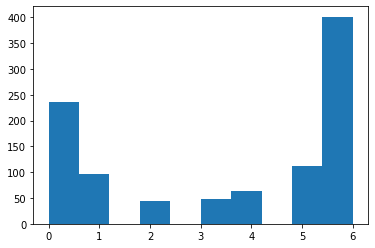

In [47]:
seed=1000
Time=1000
taste=np.random.uniform(0.5,1.5,seed)
Current_State=np.ones(seed)*4
discount1=np.ones(Time)*0.9
discount2=np.ones(Time)
State=Consumer.State(taste,Current_State,discount1,discount2,Time)
plt.hist(State)

In [112]:
taste,Preference,Discount1,Discount2=2,3,0.2,0.2
print(Consumer.Probability(taste,Preference,Discount1,Discount2,"NBundle_Seller1_Seller2"))
print(Consumer.Probability(taste,Preference,Discount1,Discount2,"NBundle_Seller2_Seller1"))
print(Consumer.Probability(taste,Preference,Discount1,Discount2,"Bundle_Seller1"))
print(Consumer.Probability(taste,Preference,Discount1,Discount2,"Bundle_Seller2"))

0.20065616994377405
0.20065616994377405
0.2993438300562259
0.2993438300562259


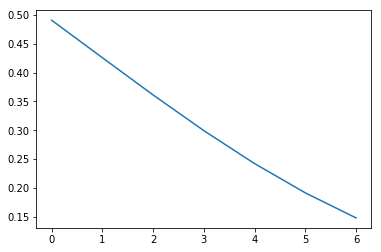

In [116]:
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,2,1,2,2
Transportation_Cost=0.1
Extra_Transportation_Cost=0.2
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4
location=np.linspace(0, 6, num=7)
P=np.zeros(7)
for i in range(7):
    P[i]=Consumer.Probability(taste,location[i],Discount1,Discount2,"Bundle_Seller1")
plt.plot(P)

(array([22.,  9.,  0.,  4.,  0.,  5.,  9.,  0., 12., 39.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

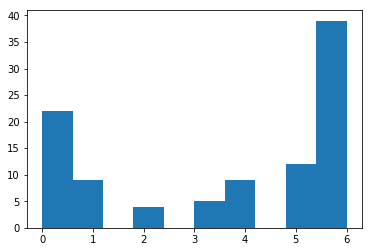

In [128]:
taste,Preference,Discount1,Discount2=0.8,3,0.5,0.6
for i in range(100):
    a[i]=Consumer.Next_Preference(taste,Preference,Discount1,Discount2,100)
plt.hist(a)

In [85]:
Consumer.Profit([0.3,0.6],[3,4],np.ones(7)*0.3,np.ones(7)*0.4,"Seller2")

2.3336152767268827

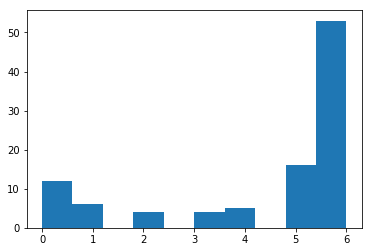

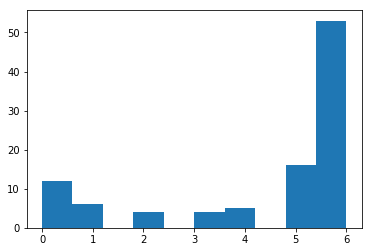

In [86]:
b=np.ones(100)*0.5
plt.hist(a)
plt.show()
plt.hist(Consumer.State(b,a,np.ones(7)*0.3,np.ones(7)*0.3,0))
plt.show()

In [87]:
#Profit(self, Taste, Current_State,Discount1,Discount2,Indicator):
def MonteCarlo_V(Taste,Current_State,Discount1,Discount2,V):
    Summation=0
    Ind=np.empty(N_agents)
    for Ind[0],Ind[1] in itertools.product(range(7), range(7)): #####
        if max(abs(Current_State[0]-Ind[0]),abs(Current_State[1]-Ind[1]))<2:
            Transition_Probability=1
            for i in range(len(Taste)):
                k=int(Current_State[i])
                if (Ind[i]-Current_State[i])>0:
                    Transition_Probability*=Consumer.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"Bundle_Seller2")
                elif (Ind[i]-Current_State[i])==0:
                    Transition_Probability*=Consumer.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"NBundle_Seller1_Seller2")+Consumer.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"NBundle_Seller2_Seller1")
                elif (Ind[i]-Current_State[i])<0:
                    Transition_Probability*=Consumer.Probability(Taste[i],Current_State[i],Discount1[k],Discount2[k],"Bundle_Seller1")
            i,j=int(Ind[0]),int(Ind[1])
            Summation+=V[i][j]*Transition_Probability
    return (Summation)

In [88]:
def Bellman(Discount,args):
    β=0.9
    Current_State=args[1:3]   #####
    Discount_Prime=args[3:10] #####
    if args[0]==1:
        Return_func=Consumer.Profit(Taste,Current_State,Discount,Discount_Prime,"Seller1")
        Expected_V=MonteCarlo_V(Taste,Current_State,Discount,Discount_Prime,V)
        
    elif args[0]==2:
        Return_func=Consumer.Profit(Taste,Current_State,Discount_Prime,Discount,"Seller2")
        Expected_V=MonteCarlo_V(Taste,Current_State,Discount_Prime,Discount,V)

        
    return -(Return_func+β*Expected_V)

In [89]:
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,2,1,2,2
Transportation_Cost=0.1
Extra_Transportation_Cost=0.2
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4

In [90]:
def solve():
    global V
    V1=np.zeros(N_states**N_agents).reshape(N_states,N_states)#####
    V2=np.zeros(N_states**N_agents).reshape(N_states,N_states)#####
    Discount1=np.ones(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)*0.1
    Discount2=np.ones(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)*0.1
    Convergence_error = 1
    tol=0.001
    Ind=np.empty(N_agents)
    while Convergence_error > tol:
        V1_New = np.empty(N_states**N_agents).reshape(N_states,N_states)#####
        V2_New = np.empty(N_states**N_agents).reshape(N_states,N_states)#####
        Discount1_New = np.zeros(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)
        Discount2_New = np.zeros(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)
        Counter=0
        Discount_table1=list(np.zeros(N_states**N_agents))
        Discount_table2=list(np.zeros(N_states**N_agents))
        # Construct args
        for Ind[0],Ind[1] in itertools.product(range(7),range(7)):
            i,j=int(Ind[0]),int(Ind[1])
            args1=np.zeros(1+N_agents)
            args2=np.zeros(1+N_agents)
            args1[0]=1
            args2[0]=2
            for s in range(len(Ind)):
                args1[s+1]=Ind[s]
                args2[s+1]=Ind[s]
            args1=np.concatenate((args1, Discount2[:][int(Counter)]), axis=0)
            args2=np.concatenate((args2, Discount1[:][int(Counter)]), axis=0)
            # Optimization 1
            V=V1    
            bnds1_H=P1+P2-c1-c2
            bnds1=((0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H))
            Discount_star=minimize(Bellman,(0,0,0,0,0,0,0),args=args1, method='SLSQP', bounds=bnds1) 
            Discount_table1[Counter]=(f"({format(Discount_star.x[i],'.2f')},{format(Discount_star.x[j],'.2f')})")
            for z in range(N_states):
                Discount1_New[int(Counter)][z]=Discount_star.x[z]
            V1_New[i][j]=-Bellman(Discount_star.x,args1)
            # Optimization 2
            V=V2
            bnds2_H=P1_Prime+P2_Prime-c1_Prime-c2_Prime
            bnds2=((0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H))
            Discount_star=minimize(Bellman,(0,0,0,0,0,0,0),args=args2, method='SLSQP', bounds=bnds2) 
            Discount_table2[Counter]=(f"({format(Discount_star.x[i],'.2f')},{format(Discount_star.x[j],'.2f')})")
            for z in range(N_states):
                Discount2_New[int(Counter)][z]=Discount_star.x[z]
            V2_New[i][j]=-Bellman(Discount_star.x,args2)
            Counter+=1
        #print("************************************************")
        Convergence_error = max(np.nanmax(np.abs(V1 -V1_New)),np.nanmax(np.abs(V2 -V2_New)))
        Discount1=Discount1_New
        #print(Convergence_error)
        Discount2=Discount2_New
        V1=V1_New
        V2=V2_New

    Headers=list(np.zeros(N_states))
    for i in range(N_states):
        Headers[i]=i
    Discount_table1=np.reshape(Discount_table1,(N_states,N_states))
    Discount_table2=np.reshape(Discount_table2,(N_states,N_states))
    V1=np.reshape(V1,(N_states,N_states))
    V2=np.reshape(V2,(N_states,N_states))
    print("Discount Seller 1")
    display(pandas.DataFrame(Discount_table1,Headers,Headers))
    print("Discount Seller 2")
    display(pandas.DataFrame(Discount_table2,Headers,Headers))
    print("Value Seller 1")
    display(pandas.DataFrame(V1,Headers,Headers))
    print("Value Seller 2")
    display(pandas.DataFrame(V2,Headers,Headers))

In [91]:
def solve_SingleSeller():
    global V
    V1=np.zeros(N_states**N_agents).reshape(N_states,N_states)#####
    V2=np.zeros(N_states**N_agents).reshape(N_states,N_states)#####
    Discount1=np.ones(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)*0.1
    Discount2=np.ones(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)*0.1
    Convergence_error = 1
    tol=0.001
    Ind=np.empty(N_agents)
    while Convergence_error > tol:
        V1_New = np.empty(N_states**N_agents).reshape(N_states,N_states)#####
        V2_New = np.empty(N_states**N_agents).reshape(N_states,N_states)#####
        Discount1_New = np.zeros(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)
        Discount2_New = np.zeros(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)
        Counter=0
        Discount_table1=list(np.zeros(N_states**N_agents))
        Discount_table2=list(np.zeros(N_states**N_agents))
        # Construct args
        for Ind[0],Ind[1] in itertools.product(range(7),range(7)):
            i,j=int(Ind[0]),int(Ind[1])
            args1=np.zeros(1+N_agents)
            args2=np.zeros(1+N_agents)
            args1[0]=1
            args2[0]=2
            for s in range(len(Ind)):
                args1[s+1]=Ind[s]
                args2[s+1]=Ind[s]
            args1=np.concatenate((args1, Discount2[:][int(Counter)]), axis=0)
            args2=np.concatenate((args2, Discount1[:][int(Counter)]), axis=0)
            # Optimization 1
            V=V1    
            bnds1_H=P1+P2-c1-c2
            bnds1=((0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H))
            Discount_star=minimize(Bellman,(0,0,0,0,0,0,0),args=args1, method='SLSQP', bounds=bnds1) 
            Discount_table1[Counter]=(f"({format(Discount_star.x[i],'.2f')},{format(Discount_star.x[j],'.2f')})")
            for z in range(N_states):
                Discount1_New[int(Counter)][z]=Discount_star.x[z]
            V1_New[i][j]=-Bellman(Discount_star.x,args1)
            # Optimization 2
            V=V2
            bnds2_H=P1_Prime+P2_Prime-c1_Prime-c2_Prime
            bnds2=((0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H))
            Discount_star=minimize(Bellman,(0,0,0,0,0,0,0),args=args2, method='SLSQP', bounds=bnds2) 
            Discount_table2[Counter]=(f"({format(Discount_star.x[i],'.2f')},{format(Discount_star.x[j],'.2f')})")
            for z in range(N_states):
                Discount2_New[int(Counter)][z]=Discount_star.x[z]
            V2_New[i][j]=-Bellman(Discount_star.x,args2)
            Counter+=1
        #print("************************************************")
        Convergence_error = max(np.nanmax(np.abs(V1 -V1_New)),np.nanmax(np.abs(V2 -V2_New)))
        Discount1=Discount1_New
        #print(Convergence_error)
        #Discount2=Discount2_New
        V1=V1_New
        V2=V2_New

    Headers=list(np.zeros(N_states))
    for i in range(N_states):
        Headers[i]=i
    Discount_table1=np.reshape(Discount_table1,(N_states,N_states))
    Discount_table2=np.reshape(Discount_table2,(N_states,N_states))
    V1=np.reshape(V1,(N_states,N_states))
    V2=np.reshape(V2,(N_states,N_states))
    print("Discount Seller 1")
    display(pandas.DataFrame(Discount_table1,Headers,Headers))
    print("Discount Seller 2")
    display(pandas.DataFrame(Discount_table2,Headers,Headers))
    print("Value Seller 1")
    display(pandas.DataFrame(V1,Headers,Headers))
    print("Value Seller 2")
    display(pandas.DataFrame(V2,Headers,Headers))

In [93]:
print("*****Homogenous Sellers, Homogenous Customers, Single Seller Decision*****")
Taste=([3,3])
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,2,1,2,2
Transportation_Cost=0.1
Extra_Transportation_Cost=0.2
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4
solve_SingleSeller()

*****Homogenous Sellers, Homogenous Customers, Single Seller Decision*****
Discount Seller 1


,0,1,2,3,4,5,6
0,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.26)","(0.00,0.59)","(0.00,1.02)","(0.00,2.02)"
1,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.17)","(0.00,0.85)","(0.00,1.63)","(0.00,2.40)"
2,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.95)","(0.00,1.95)","(0.00,2.40)"
3,"(0.26,0.00)","(0.17,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.95)","(0.00,2.05)","(0.00,2.40)"
4,"(0.59,0.00)","(0.85,0.00)","(0.95,0.00)","(0.95,0.00)","(0.93,0.93)","(0.91,2.06)","(0.79,2.40)"
5,"(1.02,0.00)","(1.63,0.00)","(1.95,0.00)","(2.05,0.00)","(2.06,0.91)","(2.01,2.01)","(1.73,2.40)"
6,"(2.02,0.00)","(2.40,0.00)","(2.40,0.00)","(2.40,0.00)","(2.40,0.79)","(2.40,1.73)","(2.40,2.40)"


Discount Seller 2


,0,1,2,3,4,5,6
0,"(2.40,2.40)","(2.40,1.77)","(2.40,0.85)","(2.40,0.22)","(2.40,0.00)","(2.40,0.00)","(2.40,0.00)"
1,"(1.77,2.40)","(2.04,2.04)","(2.11,1.00)","(2.12,0.14)","(2.11,0.00)","(2.06,0.00)","(1.83,0.00)"
2,"(0.85,2.40)","(1.00,2.11)","(1.04,1.04)","(1.05,0.06)","(1.05,0.00)","(1.03,0.00)","(0.91,0.00)"
3,"(0.22,2.40)","(0.14,2.12)","(0.06,1.05)","(0.05,0.05)","(0.06,0.00)","(0.07,0.00)","(0.09,0.00)"
4,"(0.00,2.40)","(0.00,2.11)","(0.00,1.05)","(0.00,0.06)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
5,"(0.00,2.40)","(0.00,2.06)","(0.00,1.03)","(0.00,0.07)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
6,"(0.00,2.40)","(0.00,1.83)","(0.00,0.91)","(0.00,0.09)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"


Value Seller 1


,0,1,2,3,4,5,6
0,4.677684,6.263293,6.739305,6.700285,6.391956,5.785187,4.416635
1,6.263293,9.997597,11.600521,11.875935,11.417429,10.281946,7.799815
2,6.739305,11.600521,14.268352,15.040991,14.603621,13.225460,9.980457
3,6.700285,11.875935,15.040991,16.157685,15.792837,14.350529,10.794225
4,6.391956,11.417429,14.603621,15.792837,15.458595,14.025191,10.502349
5,5.785187,10.281946,13.225460,14.350529,14.025191,12.637812,9.339105
6,4.416635,7.799815,9.980457,10.794225,10.502349,9.339105,6.771658


Value Seller 2


,0,1,2,3,4,5,6
0,8.069575,10.908521,12.182900,12.572077,12.353898,11.269164,8.382193
1,10.908521,14.523544,16.050577,16.552526,16.187393,14.948377,11.751603
2,12.182900,16.050577,17.635983,18.224368,17.763875,16.562571,13.092107
3,12.572078,16.552526,18.224368,18.816045,18.359569,17.162176,13.602243
4,12.353898,16.187393,17.763875,18.359569,17.914316,16.728723,13.246619
5,11.269164,14.948377,16.562571,17.162175,16.728722,15.558004,12.227335
6,8.382193,11.751603,13.092107,13.602243,13.246619,12.227335,9.668885


In [94]:
print("*****Homogenous Sellers, Homogenous Customers*****")
Taste=([3,3])
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,2,1,2,2
Transportation_Cost=0.1
Extra_Transportation_Cost=0.2
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4
solve()

*****Homogenous Sellers, Homogenous Customers*****
Discount Seller 1


,0,1,2,3,4,5,6
0,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.14)","(0.00,0.86)","(0.00,1.78)","(0.00,2.40)"
1,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.09)","(0.00,0.99)","(0.00,2.03)","(0.00,2.40)"
2,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.08)","(0.00,1.01)","(0.00,2.09)","(0.00,2.40)"
3,"(0.14,0.00)","(0.09,0.00)","(0.08,0.00)","(0.08,0.08)","(0.08,1.01)","(0.09,2.09)","(0.14,2.40)"
4,"(0.86,0.00)","(0.99,0.00)","(1.01,0.00)","(1.01,0.08)","(1.01,1.01)","(0.98,2.08)","(0.85,2.40)"
5,"(1.78,0.00)","(2.03,0.00)","(2.09,0.00)","(2.09,0.09)","(2.08,0.98)","(2.03,2.03)","(1.76,2.40)"
6,"(2.40,0.00)","(2.40,0.00)","(2.40,0.00)","(2.40,0.14)","(2.40,0.85)","(2.40,1.76)","(2.40,2.40)"


Discount Seller 2


,0,1,2,3,4,5,6
0,"(2.40,2.40)","(2.40,1.76)","(2.40,0.85)","(2.40,0.14)","(2.40,0.00)","(2.40,0.00)","(2.40,0.00)"
1,"(1.76,2.40)","(2.03,2.03)","(2.08,0.98)","(2.09,0.09)","(2.09,0.00)","(2.03,0.00)","(1.78,0.00)"
2,"(0.85,2.40)","(0.98,2.08)","(1.01,1.01)","(1.01,0.08)","(1.01,0.00)","(0.99,0.00)","(0.86,0.00)"
3,"(0.14,2.40)","(0.09,2.09)","(0.08,1.01)","(0.08,0.08)","(0.08,0.00)","(0.09,0.00)","(0.14,0.00)"
4,"(0.00,2.40)","(0.00,2.09)","(0.00,1.01)","(0.00,0.08)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
5,"(0.00,2.40)","(0.00,2.03)","(0.00,0.99)","(0.00,0.09)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
6,"(0.00,2.40)","(0.00,1.78)","(0.00,0.86)","(0.00,0.14)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"


Value Seller 1


,0,1,2,3,4,5,6
0,9.578896,12.102492,13.088167,13.409055,12.984453,11.696167,8.795093
1,12.102492,15.385104,16.518458,16.938961,16.418132,14.897804,11.235850
2,13.088167,16.518458,17.669678,18.105126,17.569719,16.015863,12.204608
3,13.409056,16.938961,18.105126,18.545087,18.005787,16.433529,12.524348
4,12.984453,16.418132,17.569719,18.005787,17.470493,15.915422,12.101810
5,11.696167,14.897804,16.015863,16.433529,15.915422,14.408838,10.828775
6,8.795093,11.235850,12.204609,12.524348,12.101810,10.828775,8.010514


Value Seller 2


,0,1,2,3,4,5,6
0,8.010514,10.828775,12.101810,12.524347,12.204609,11.235850,8.795093
1,10.828775,14.408838,15.915422,16.433529,16.015863,14.897804,11.696167
2,12.101810,15.915422,17.470492,18.005786,17.569719,16.418132,12.984453
3,12.524347,16.433528,18.005786,18.545087,18.105127,16.938961,13.409057
4,12.204609,16.015863,17.569719,18.105126,17.669678,16.518459,13.088167
5,11.235850,14.897804,16.418133,16.938962,16.518459,15.385104,12.102492
6,8.795093,11.696167,12.984453,13.409057,13.088168,12.102492,9.578896


In [95]:
print("*****Homogenous Sellers, Homogenous Customers, Increase Transportation Cost*****")
Taste=([3,3])
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,2,1,2,2
Transportation_Cost=0.1
Extra_Transportation_Cost=0.4
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4
solve()

*****Homogenous Sellers, Homogenous Customers, Increase Transportation Cost*****
Discount Seller 1


,0,1,2,3,4,5,6
0,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.14)","(0.00,0.86)","(0.00,1.78)","(0.00,2.40)"
1,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.09)","(0.00,0.99)","(0.00,2.03)","(0.00,2.40)"
2,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.08)","(0.00,1.01)","(0.00,2.09)","(0.00,2.40)"
3,"(0.14,0.00)","(0.09,0.00)","(0.08,0.00)","(0.08,0.08)","(0.08,1.01)","(0.09,2.09)","(0.14,2.40)"
4,"(0.86,0.00)","(0.99,0.00)","(1.01,0.00)","(1.01,0.08)","(1.01,1.01)","(0.98,2.08)","(0.85,2.40)"
5,"(1.78,0.00)","(2.03,0.00)","(2.09,0.00)","(2.09,0.09)","(2.08,0.98)","(2.03,2.03)","(1.76,2.40)"
6,"(2.40,0.00)","(2.40,0.00)","(2.40,0.00)","(2.40,0.14)","(2.40,0.85)","(2.40,1.76)","(2.40,2.40)"


Discount Seller 2


,0,1,2,3,4,5,6
0,"(2.40,2.40)","(2.40,1.76)","(2.40,0.85)","(2.40,0.14)","(2.40,0.00)","(2.40,0.00)","(2.40,0.00)"
1,"(1.76,2.40)","(2.03,2.03)","(2.08,0.98)","(2.09,0.09)","(2.09,0.00)","(2.03,0.00)","(1.78,0.00)"
2,"(0.85,2.40)","(0.98,2.08)","(1.01,1.01)","(1.01,0.08)","(1.01,0.00)","(0.99,0.00)","(0.86,0.00)"
3,"(0.14,2.40)","(0.09,2.09)","(0.08,1.01)","(0.08,0.08)","(0.08,0.00)","(0.09,0.00)","(0.14,0.00)"
4,"(0.00,2.40)","(0.00,2.09)","(0.00,1.01)","(0.00,0.08)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
5,"(0.00,2.40)","(0.00,2.03)","(0.00,0.99)","(0.00,0.09)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
6,"(0.00,2.40)","(0.00,1.78)","(0.00,0.86)","(0.00,0.14)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"


Value Seller 1


,0,1,2,3,4,5,6
0,9.578896,12.102492,13.088167,13.409055,12.984453,11.696167,8.795093
1,12.102492,15.385104,16.518458,16.938961,16.418132,14.897804,11.235850
2,13.088167,16.518458,17.669678,18.105126,17.569719,16.015863,12.204608
3,13.409056,16.938961,18.105126,18.545087,18.005787,16.433529,12.524348
4,12.984453,16.418132,17.569719,18.005787,17.470493,15.915422,12.101810
5,11.696167,14.897804,16.015863,16.433529,15.915422,14.408838,10.828775
6,8.795093,11.235850,12.204609,12.524348,12.101810,10.828775,8.010514


Value Seller 2


,0,1,2,3,4,5,6
0,8.010514,10.828775,12.101810,12.524347,12.204609,11.235850,8.795093
1,10.828775,14.408838,15.915422,16.433529,16.015863,14.897804,11.696167
2,12.101810,15.915422,17.470492,18.005786,17.569719,16.418132,12.984453
3,12.524347,16.433528,18.005786,18.545087,18.105127,16.938961,13.409057
4,12.204609,16.015863,17.569719,18.105126,17.669678,16.518459,13.088167
5,11.235850,14.897804,16.418133,16.938962,16.518459,15.385104,12.102492
6,8.795093,11.696167,12.984453,13.409057,13.088168,12.102492,9.578896


In [96]:
print("*****Homogenous Sellers, Heterogenous Customers*****")
Taste=([3,1])
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,2,1,2,2
Transportation_Cost=0.1
Extra_Transportation_Cost=0.2
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4
solve()

*****Homogenous Sellers, Heterogenous Customers*****
Discount Seller 1


,0,1,2,3,4,5,6
0,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.14)","(0.00,0.86)","(0.00,1.78)","(0.00,2.40)"
1,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.09)","(0.00,0.99)","(0.00,2.03)","(0.00,2.40)"
2,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.08)","(0.00,1.01)","(0.00,2.09)","(0.00,2.40)"
3,"(0.14,0.00)","(0.09,0.00)","(0.08,0.00)","(0.08,0.08)","(0.08,1.01)","(0.09,2.09)","(0.14,2.40)"
4,"(0.86,0.00)","(0.99,0.00)","(1.01,0.00)","(1.01,0.08)","(1.01,1.01)","(0.98,2.08)","(0.85,2.40)"
5,"(1.78,0.00)","(2.03,0.00)","(2.09,0.00)","(2.09,0.09)","(2.08,0.98)","(2.03,2.03)","(1.76,2.40)"
6,"(2.40,0.00)","(2.40,0.00)","(2.40,0.00)","(2.40,0.14)","(2.40,0.85)","(2.40,1.76)","(2.40,2.40)"


Discount Seller 2


,0,1,2,3,4,5,6
0,"(2.40,2.40)","(2.40,1.76)","(2.40,0.85)","(2.40,0.14)","(2.40,0.00)","(2.40,0.00)","(2.40,0.00)"
1,"(1.76,2.40)","(2.03,2.03)","(2.08,0.98)","(2.09,0.09)","(2.09,0.00)","(2.03,0.00)","(1.78,0.00)"
2,"(0.85,2.40)","(0.98,2.08)","(1.01,1.01)","(1.01,0.08)","(1.01,0.00)","(0.99,0.00)","(0.86,0.00)"
3,"(0.14,2.40)","(0.09,2.09)","(0.08,1.01)","(0.08,0.08)","(0.08,0.00)","(0.09,0.00)","(0.14,0.00)"
4,"(0.00,2.40)","(0.00,2.09)","(0.00,1.01)","(0.00,0.08)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
5,"(0.00,2.40)","(0.00,2.03)","(0.00,0.99)","(0.00,0.09)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
6,"(0.00,2.40)","(0.00,1.78)","(0.00,0.86)","(0.00,0.14)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"


Value Seller 1


,0,1,2,3,4,5,6
0,9.578896,12.102492,13.088167,13.409055,12.984453,11.696167,8.795092
1,12.102491,15.385104,16.518458,16.938961,16.418132,14.897804,11.235850
2,13.088167,16.518458,17.669678,18.105125,17.569719,16.015863,12.204609
3,13.409059,16.938961,18.105126,18.545087,18.005786,16.433528,12.524347
4,12.984453,16.418132,17.569719,18.005786,17.470492,15.915422,12.101810
5,11.696167,14.897804,16.015863,16.433528,15.915422,14.408837,10.828775
6,8.795093,11.235850,12.204608,12.524348,12.101810,10.828775,8.010514


Value Seller 2


,0,1,2,3,4,5,6
0,8.010514,10.828775,12.101810,12.524348,12.204609,11.235850,8.795093
1,10.828775,14.408837,15.915422,16.433528,16.015863,14.897804,11.696167
2,12.101810,15.915422,17.470492,18.005786,17.569719,16.418132,12.984453
3,12.524347,16.433528,18.005786,18.545087,18.105126,16.938961,13.409055
4,12.204609,16.015863,17.569719,18.105126,17.669678,16.518458,13.088167
5,11.235850,14.897804,16.418132,16.938961,16.518458,15.385104,12.102491
6,8.795093,11.696167,12.984453,13.409055,13.088167,12.102492,9.578896


In [97]:
print("*****Heterogenous Sellers, Homogenous Customers*****")
Taste=([3,3])
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,4,2.5,1,1
Transportation_Cost=0.1
Extra_Transportation_Cost=0.1
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4
solve()

*****Heterogenous Sellers, Homogenous Customers*****
Discount Seller 1


,0,1,2,3,4,5,6
0,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.17)","(0.00,0.92)","(0.00,1.89)","(0.00,2.40)"
1,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.15)","(0.00,1.01)","(0.00,2.06)","(0.00,2.40)"
2,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.14)","(0.00,1.03)","(0.00,2.10)","(0.00,2.40)"
3,"(0.17,0.00)","(0.15,0.00)","(0.14,0.00)","(0.14,0.14)","(0.14,1.03)","(0.15,2.11)","(0.19,2.40)"
4,"(0.92,0.00)","(1.01,0.00)","(1.03,0.00)","(1.03,0.14)","(1.02,1.02)","(1.00,2.09)","(0.87,2.40)"
5,"(1.89,0.00)","(2.06,0.00)","(2.10,0.00)","(2.11,0.15)","(2.09,1.00)","(2.04,2.04)","(1.77,2.40)"
6,"(2.40,0.00)","(2.40,0.00)","(2.40,0.00)","(2.40,0.19)","(2.40,0.87)","(2.40,1.77)","(2.40,2.40)"


Discount Seller 2


,0,1,2,3,4,5,6
0,"(2.90,2.90)","(2.90,1.75)","(2.90,0.85)","(2.90,0.13)","(2.90,0.00)","(2.90,0.00)","(2.90,0.00)"
1,"(1.75,2.90)","(1.91,1.91)","(1.94,0.93)","(1.95,0.09)","(1.95,0.00)","(1.91,0.00)","(1.67,0.00)"
2,"(0.85,2.90)","(0.93,1.94)","(0.94,0.94)","(0.95,0.09)","(0.94,0.00)","(0.92,0.00)","(0.81,0.00)"
3,"(0.13,2.90)","(0.09,1.95)","(0.09,0.95)","(0.09,0.09)","(0.09,0.00)","(0.10,0.00)","(0.15,0.00)"
4,"(0.00,2.90)","(0.00,1.95)","(0.00,0.94)","(0.00,0.09)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
5,"(0.00,2.90)","(0.00,1.91)","(0.00,0.92)","(0.00,0.10)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
6,"(0.00,2.90)","(0.00,1.67)","(0.00,0.81)","(0.00,0.15)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"


Value Seller 1


,0,1,2,3,4,5,6
0,11.226136,13.440239,14.344201,14.634870,14.150987,12.760106,9.562512
1,13.440239,16.010681,17.002638,17.352940,16.800741,15.256241,11.538422
2,14.344201,17.002638,18.010774,18.371071,17.807998,16.233939,12.374877
3,14.634872,17.352939,18.371070,18.734160,18.167920,16.576932,12.631145
4,14.150987,16.800741,17.807998,18.167921,17.605720,16.032471,12.186340
5,12.760106,15.256241,16.233939,16.576932,16.032471,14.508395,10.899401
6,9.562512,11.538422,12.374877,12.631145,12.186339,10.899401,8.062096


Value Seller 2


,0,1,2,3,4,5,6
0,8.859224,11.600792,12.847603,13.248181,12.893591,11.873987,9.192245
1,11.600792,14.716501,16.106807,16.563391,16.144821,15.030151,11.812758
2,12.847603,16.106807,17.527974,17.995267,17.563681,16.422080,12.992954
3,13.248182,16.563390,17.995267,18.464576,18.030443,16.876600,13.364173
4,12.893591,16.144820,17.563681,18.030443,17.600560,16.461066,13.045686
5,11.873987,15.030151,16.422080,16.876601,16.461066,15.338516,12.068497
6,9.192245,11.812758,12.992953,13.364173,13.045685,12.068497,9.554602


In [123]:
print("*****Heterogenous Sellers, Heterogenous Customers*****")
Taste=([3,0.5])
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,4,2.5,1.2,0.7
Transportation_Cost=0.1
Extra_Transportation_Cost=0.1
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4
solve()

*****Heterogenous Sellers, Heterogenous Customers*****
Discount Seller 1


,0,1,2,3,4,5,6
0,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.15)","(0.00,0.89)","(0.00,1.83)","(0.00,2.40)"
1,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.11)","(0.00,0.99)","(0.00,2.04)","(0.00,2.40)"
2,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.10)","(0.00,1.01)","(0.00,2.09)","(0.00,2.40)"
3,"(0.15,0.00)","(0.11,0.00)","(0.10,0.00)","(0.10,0.10)","(0.10,1.02)","(0.11,2.10)","(0.16,2.40)"
4,"(0.89,0.00)","(0.99,0.00)","(1.01,0.00)","(1.02,0.10)","(1.01,1.01)","(0.99,2.09)","(0.86,2.40)"
5,"(1.83,0.00)","(2.04,0.00)","(2.09,0.00)","(2.10,0.11)","(2.09,0.99)","(2.03,2.03)","(1.77,2.40)"
6,"(2.40,0.00)","(2.40,0.00)","(2.40,0.00)","(2.40,0.16)","(2.40,0.86)","(2.40,1.77)","(2.40,2.40)"


Discount Seller 2


,0,1,2,3,4,5,6
0,"(2.60,2.60)","(2.60,1.76)","(2.60,0.85)","(2.60,0.14)","(2.60,0.00)","(2.60,0.00)","(2.60,0.00)"
1,"(1.76,2.60)","(1.97,1.97)","(2.02,0.96)","(2.03,0.09)","(2.02,0.00)","(1.98,0.00)","(1.73,0.00)"
2,"(0.85,2.60)","(0.96,2.02)","(0.98,0.98)","(0.98,0.08)","(0.98,0.00)","(0.96,0.00)","(0.84,0.00)"
3,"(0.14,2.60)","(0.09,2.03)","(0.08,0.98)","(0.08,0.08)","(0.08,0.00)","(0.10,0.00)","(0.14,0.00)"
4,"(0.00,2.60)","(0.00,2.02)","(0.00,0.98)","(0.00,0.08)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
5,"(0.00,2.60)","(0.00,1.98)","(0.00,0.96)","(0.00,0.10)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
6,"(0.00,2.60)","(0.00,1.73)","(0.00,0.84)","(0.00,0.14)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"


Value Seller 1


,0,1,2,3,4,5,6
0,10.248310,12.657807,13.613807,13.924941,13.475539,12.143407,9.118091
1,12.657807,15.635251,16.712311,17.104844,16.571434,15.041784,11.358581
2,13.613807,16.712310,17.807077,18.213033,17.666288,16.104328,12.273887
3,13.924939,17.104845,18.213033,18.623023,18.072669,16.492905,12.568407
4,13.475539,16.571434,17.666288,18.072668,17.526223,15.963637,12.136666
5,12.143407,15.041784,16.104328,16.492904,15.963636,14.449813,10.857830
6,9.118091,11.358581,12.273887,12.568407,12.136666,10.857830,8.031724


Value Seller 2


,0,1,2,3,4,5,6
0,8.409761,11.192822,12.454490,12.868791,12.532855,11.540254,8.995184
1,11.192822,14.554762,16.008705,16.500487,16.081565,14.964262,11.754323
2,12.454490,16.008705,17.503747,18.010119,17.574964,16.426802,12.993394
3,12.868792,16.500487,18.010119,18.519840,18.081274,16.919821,13.394827
4,12.532856,16.081565,17.574964,18.081274,17.646982,16.499772,13.074282
5,11.540254,14.964262,16.426803,16.919821,16.499772,15.370133,12.091452
6,8.995184,11.754323,12.993394,13.394826,13.074282,12.091452,9.571044


In [ ]:
print("*****Homogenous Sellers, Heterogenous Customers, Increase Transportation Cost*****")
Taste=([3,1])
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,4,2.5,1,1
Transportation_Cost=0.1
Extra_Transportation_Cost=0.5
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4
solve()

In [119]:
def solve_NoBundling():
    global V
    V1=np.zeros(N_states**N_agents).reshape(N_states,N_states)#####
    V2=np.zeros(N_states**N_agents).reshape(N_states,N_states)#####
    Discount1=np.zeros(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)
    Discount2=np.zeros(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)
    Convergence_error = 1
    tol=0.001
    Ind=np.empty(N_agents)
    while Convergence_error > tol:
        V1_New = np.empty(N_states**N_agents).reshape(N_states,N_states)#####
        V2_New = np.empty(N_states**N_agents).reshape(N_states,N_states)#####
        Discount1_New = np.zeros(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)
        Discount2_New = np.zeros(N_states*(N_states**N_agents)).reshape(N_states**N_agents,N_states)
        Counter=0
        Discount_table1=list(np.zeros(N_states**N_agents))
        Discount_table2=list(np.zeros(N_states**N_agents))
        # Construct args
        for Ind[0],Ind[1] in itertools.product(range(7),range(7)):
            i,j=int(Ind[0]),int(Ind[1])
            args1=np.zeros(1+N_agents)
            args2=np.zeros(1+N_agents)
            args1[0]=1
            args2[0]=2
            for s in range(len(Ind)):
                args1[s+1]=Ind[s]
                args2[s+1]=Ind[s]
            args1=np.concatenate((args1, Discount2[:][int(Counter)]), axis=0)
            args2=np.concatenate((args2, Discount1[:][int(Counter)]), axis=0)
            # Optimization 1
            V=V1    
            bnds1_H=P1+P2-c1-c2
            bnds1=((0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H),(0,bnds1_H))
            Discount_star=minimize(Bellman,(0,0,0,0,0,0,0),args=args1, method='SLSQP', bounds=bnds1) 
            Discount_table1[Counter]=(f"({format(Discount_star.x[i],'.2f')},{format(Discount_star.x[j],'.2f')})")
            for z in range(N_states):
                Discount1_New[int(Counter)][z]=Discount_star.x[z]
            V1_New[i][j]=-Bellman(Discount_star.x,args1)
            # Optimization 2
            V=V2
            bnds2_H=P1_Prime+P2_Prime-c1_Prime-c2_Prime
            bnds2=((0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H),(0,bnds2_H))
            Discount_star=minimize(Bellman,(0,0,0,0,0,0,0),args=args2, method='SLSQP', bounds=bnds2) 
            Discount_table2[Counter]=(f"({format(Discount_star.x[i],'.2f')},{format(Discount_star.x[j],'.2f')})")
            for z in range(N_states):
                Discount2_New[int(Counter)][z]=Discount_star.x[z]
            V2_New[i][j]=-Bellman(Discount_star.x,args2)
            Counter+=1
        #print("************************************************")
        Convergence_error = max(np.nanmax(np.abs(V1 -V1_New)),np.nanmax(np.abs(V2 -V2_New)))
        #Discount1=Discount1_New
        #print(Convergence_error)
        #Discount2=Discount2_New
        V1=V1_New
        V2=V2_New

    Headers=list(np.zeros(N_states))
    for i in range(N_states):
        Headers[i]=i
    Discount_table1=np.reshape(Discount_table1,(N_states,N_states))
    Discount_table2=np.reshape(Discount_table2,(N_states,N_states))
    V1=np.reshape(V1,(N_states,N_states))
    V2=np.reshape(V2,(N_states,N_states))
    print("Discount Seller 1")
    display(pandas.DataFrame(Discount_table1,Headers,Headers))
    print("Discount Seller 2")
    display(pandas.DataFrame(Discount_table2,Headers,Headers))
    print("Value Seller 1")
    display(pandas.DataFrame(V1,Headers,Headers))
    print("Value Seller 2")
    display(pandas.DataFrame(V2,Headers,Headers))

In [120]:
print("*****Homogenous Sellers, Homogenous Customers, No Bundling*****")
Taste=([3,3])
S1,P1,S2,P2,S1_Prime,P1_Prime,S2_Prime,P2_Prime=2,1,2,2,2,1,2,2
Transportation_Cost=0.1
Extra_Transportation_Cost=0.2
Distance=6
c1,c2,c1_Prime,c2_Prime=0.2,0.4,0.2,0.4
solve_NoBundling()

*****Homogenous Sellers, Homogenous Customers, No Bundling*****
Discount Seller 1


,0,1,2,3,4,5,6
0,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.22)","(0.00,0.53)","(0.00,0.94)","(0.00,1.92)"
1,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.10)","(0.00,0.76)","(0.00,1.52)","(0.00,2.40)"
2,"(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.84)","(0.00,1.83)","(0.00,2.40)"
3,"(0.22,0.00)","(0.10,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.82)","(0.00,1.94)","(0.00,2.40)"
4,"(0.53,0.00)","(0.76,0.00)","(0.84,0.00)","(0.82,0.00)","(0.80,0.80)","(0.77,1.95)","(0.68,2.40)"
5,"(0.94,0.00)","(1.52,0.00)","(1.83,0.00)","(1.94,0.00)","(1.95,0.77)","(1.90,1.90)","(1.66,2.40)"
6,"(1.92,0.00)","(2.40,0.00)","(2.40,0.00)","(2.40,0.00)","(2.40,0.68)","(2.40,1.66)","(2.40,2.40)"


Discount Seller 2


,0,1,2,3,4,5,6
0,"(2.40,2.40)","(2.40,1.66)","(2.40,0.68)","(2.40,0.00)","(2.40,0.00)","(2.40,0.00)","(1.92,0.00)"
1,"(1.66,2.40)","(1.90,1.90)","(1.95,0.77)","(1.94,0.00)","(1.83,0.00)","(1.52,0.00)","(0.94,0.00)"
2,"(0.68,2.40)","(0.77,1.95)","(0.80,0.80)","(0.82,0.00)","(0.84,0.00)","(0.76,0.00)","(0.53,0.00)"
3,"(0.00,2.40)","(0.00,1.94)","(0.00,0.82)","(0.00,0.00)","(0.00,0.00)","(0.10,0.00)","(0.22,0.00)"
4,"(0.00,2.40)","(0.00,1.83)","(0.00,0.84)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
5,"(0.00,2.40)","(0.00,1.52)","(0.00,0.76)","(0.00,0.10)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"
6,"(0.00,1.92)","(0.00,0.94)","(0.00,0.53)","(0.00,0.22)","(0.00,0.00)","(0.00,0.00)","(0.00,0.00)"


Value Seller 1


,0,1,2,3,4,5,6
0,4.653664,6.206849,6.670967,6.640830,6.356944,5.792409,4.472420
1,6.206849,9.925747,11.542949,11.861036,11.451356,10.380844,7.983529
2,6.670967,11.542949,14.292059,15.177189,14.817629,13.513755,10.370428
3,6.640830,11.861036,15.177189,16.476735,16.222627,14.860102,11.384658
4,6.356944,11.451356,14.817629,16.222627,16.015296,14.662806,11.195932
5,5.792409,10.380844,13.513755,14.860102,14.662806,13.351121,10.078280
6,4.472420,7.983529,10.370428,11.384658,11.195932,10.078280,7.462501


Value Seller 2


,0,1,2,3,4,5,6
0,7.462501,10.078280,11.195932,11.384658,10.370428,7.983529,4.472420
1,10.078280,13.351121,14.662806,14.860102,13.513755,10.380844,5.792409
2,11.195932,14.662806,16.015296,16.222627,14.817629,11.451356,6.356944
3,11.384658,14.860102,16.222627,16.476735,15.177189,11.861036,6.640830
4,10.370428,13.513755,14.817629,15.177189,14.292059,11.542949,6.670967
5,7.983529,10.380844,11.451356,11.861036,11.542949,9.925747,6.206849
6,4.472420,5.792409,6.356944,6.640830,6.670967,6.206849,4.653664


In [ ]:
Discount_table2=list(np.zeros(49))
counter=0
for  m range(7):
    for n in range(7):
        Discount_table2[counter]=(f"({i},{j})")
        counter+=1
Discount_table2=np.reshape(Discount_table2, (7, 7))
Discount_table2

args1=np.zeros(1+N_agents)
Discount1=(np.ones(N_states*(N_states**N_agents)).reshape(N_states,N_states**N_agents))*0.1
#args1+=Discount1[:,N_states]      
args1=np.concatenate((args1, Discount1[:,N_states]), axis=0)
args1

TU=np.empty(3).tolist()
TT=[4,5,6]
TY=[7,8,9]
TT=list(zip(TU,TT,TY))
TT=list(zip(TU,TT))